In [1]:
import os
import src.mylib

keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
key=src.mylib.getKey(keyPath)

print (key['dataseoul'])
print (key['gokr'])

# seoul api

In [6]:
import os
import src.mylib

keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
key=src.mylib.getKey(keyPath)
KEY = str(key['dataseoul'])

#api
TYPE='json'
SERVICE = 'SearchSTNBySubwayLineInfo'
START_INDEX=str(1)
END_INDEX=str(10)
LINE_NUM=str(2)

params='/'.join([KEY,TYPE,SERVICE,START_INDEX,END_INDEX,'','',LINE_NUM])

_url = 'http://openAPI.seoul.go.kr:8088'
url='/'.join([_url,params])

In [8]:
import requests

r = requests.get(url)

stations=r.json()

for e in stations['SearchSTNBySubwayLineInfo']['row']:
    print ("{0:4s}\t{1:15s}\t{2:3s}\t{3:2s}".format(e['STATION_CD'], e['STATION_NM'], e['FR_CODE'], e['LINE_NUM']))

0159	동묘앞            	127	01호선
0416	미아사거리          	416	04호선
0423	충무로            	423	04호선
1004	노량진            	136	01호선
1010	한남             	K113	경의선
0309	지축             	319	03호선
0321	충무로            	331	03호선
0333	매봉             	343	03호선
0340	가락시장           	350	03호선
0424	명동             	424	04호선


# while json seoul api

In [9]:
%%writefile src/ds_open_subway_iter_json.py
#!/usr/bin/env python
# coding: utf-8
import os
import requests
import urllib
import mylib # NO! src.mylib

def doIt():
    keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
    key=mylib.getKey(keyPath)
    # (1) make params with resource IDs
    KEY=str(key['dataseoul'])
    TYPE='json'
    #OLD: SERVICE='SearchSTNBySubwayLineService'
    SERVICE='SearchSTNBySubwayLineInfo'
    LINE_NUM=str(2)
    START_INDEX=str(1)
    END_INDEX=str(10)
    startIndex=1
    endIndex=10
    list_total_count=0    # set later
    while True:
        START_INDEX=str(startIndex)
        END_INDEX=str(endIndex)
        #params=os.path.join(KEY,TYPE,SERVICE,START_INDEX,END_INDEX,LINE_NUM)
        params="/".join([KEY,TYPE,SERVICE,START_INDEX,END_INDEX,'','',LINE_NUM])
        # (2) make a full url
        _url='http://openAPI.seoul.go.kr:8088' #NOTE slash: do not use 'http://openAPI.seoul.go.kr:8088/'
        #url=urllib.parse.urljoin(_url,params)
        url="/".join([_url,params])
        #print(url)
        # (3) get data
        r=requests.get(url)
        #print(r)
        stations=r.json()
        #print(stations)
        if(startIndex==1):
            list_total_count=stations['SearchSTNBySubwayLineInfo']['list_total_count']
            print("- Total Count: ", list_total_count)
        for e in stations['SearchSTNBySubwayLineInfo']['row']:
            print (u"{0:4s}\t{1:15s}\t{2:3s}\t{3:2s}".format(e['STATION_CD'], e['STATION_NM'], e['FR_CODE'], e['LINE_NUM']))
        startIndex+=10
        endIndex+=10
        if(endIndex > list_total_count):
            print("----- Ending endIndex=",endIndex)
            break  # exit from the while loop

if __name__ == "__main__":
    doIt()

Overwriting src/ds_open_subway_iter_json.py


# while xml seoul

In [ ]:
%%writefile src/ds_open_subway_xml.py
#!/usr/bin/env python
# coding: utf-8
import os
import requests
import urllib
import mylib # NO! src.mylib
import lxml
import lxml.etree
from io import StringIO

def doIt():
    keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
    key=mylib.getKey(keyPath)
    # (1) make params with resource IDs
    KEY=str(key['dataseoul'])
    TYPE='xml'
    #OLD: SERVICE='SearchSTNBySubwayLineService'
    SERVICE='SearchSTNBySubwayLineInfo'
    LINE_NUM=str(2)
    START_INDEX=str(1)
    END_INDEX=str(10)
    startIndex=1
    endIndex=10
    list_total_count=0    # set later
    while True:
        START_INDEX=str(startIndex)
        END_INDEX=str(endIndex)
        #params=os.path.join(KEY,TYPE,SERVICE,START_INDEX,END_INDEX,LINE_NUM)
        params="/".join([KEY,TYPE,SERVICE,START_INDEX,END_INDEX,'','',LINE_NUM])
        # (2) make a full url
        _url='http://openAPI.seoul.go.kr:8088' #NOTE slash: do not use 'http://openAPI.seoul.go.kr:8088/'
        #url=urllib.parse.urljoin(_url,params)
        url="/".join([_url,params])
        #print(url)
        # (3) get data
        data=requests.get(url).text
        #tree=lxml.etree.parse(StringIO(data.encode('utf-8')))
        tree=lxml.etree.fromstring(data.encode('utf-8'))
        if(startIndex==1):
            for node in tree.xpath('//list_total_count'):
                list_total_count=int(node.text)
                print ("- Total_count=",list_total_count)
        for node in tree.xpath('//STATION_NM'):
            print (node.text, end=", ")
        startIndex+=10
        endIndex+=10
        if(endIndex > list_total_count):
            print("----- Ending endIndex=", endIndex)
            break

if __name__ == "__main__":
    doIt()

# mongo db

In [18]:
import pymongo

Client = pymongo.MongoClient('mongodb://localhost:27017')
db=Client.myDB

In [14]:
%%writefile src/ds_open_subwayTime.py
# coding: utf-8
import os
import requests
import json
from pymongo import MongoClient
import mylib

Client = MongoClient('localhost:27017')
_db=Client['ds_open_subwayPassengersDb'] #db created by mongo. You do not have to create this.
_table=_db['db_open_subwayTable'] #collection
#db=Client.ds_rest_subwayPassengers

def saveJson(_fname,_data):
    import io
    with io.open(_fname, 'a', encoding='utf8') as json_file:
        #_j=json.dumps(_data, json_file, ensure_ascii=False, encoding='utf8') # python2
        _j=json.dump(_data, json_file, ensure_ascii=False)
        json_file.write(str(_j)+"\n")

def readJson(_fname):
    for line in open(_fname, 'r').readlines():
        _j=json.loads(line)
        #print _j['id'],_j['text']
        print (_j['id'])

def saveDB(_data):
    _table.insert_one(_data)

def readDB():
    for tweet in _table.find():
        print (tweet['id'],tweet['text'])

def saveFile(_fname,_data):
    fp=open(_fname,'a')
    fp.write(_data+"\n")
    fp.close()

def doIt():
    keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
    key=mylib.getKey(keyPath)  
    _key=key['dataseoul'] #KEY='73725.....'
    _url='http://openAPI.seoul.go.kr:8088'
    _type='json'
    _service='CardSubwayTime'
    _start_index=1
    _end_index=5
    _use_mon='202106'
    _maxIter=20
    _iter=0
    _jfname='src/ds_open_subwayTime.json'
    while _iter<_maxIter:
        _api="/".join([_url,_key,_type,_service,str(_start_index),str(_end_index),_use_mon])
        #print _api
        r=requests.get(_api)
        _json=r.json()
        print (_json)
        saveJson(_jfname,_json)
        saveDB(_json)
        _start_index+=5
        _end_index+=5
        _iter+=1

if __name__ == "__main__":
    doIt()


ServerSelectionTimeoutError: localhost:27017: [Errno 61] Connection refused, Timeout: 30s, Topology Description: <TopologyDescription id: 6170c202c5b2fe9e65886fbd, topology_type: Single, servers: [<ServerDescription ('localhost', 27017) server_type: Unknown, rtt: None, error=AutoReconnect('localhost:27017: [Errno 61] Connection refused')>]>

In [ ]:
print(Client.list_database_names())
db=Client.ds_open_subwayPassengersDb

In [ ]:
db.list_collection_names()

In [ ]:
db.db_open_subwayTable.count_documents({})

In [ ]:
db.db_open_subwayTable.find_one()

# 공공데이터 포털

In [26]:
%%writefile 예제/src/key.properties
gokr=D79VsERJpMFwSWkbjfAJ%2B4AKxwn%2FiuYjMueXWqAFutQbkgVvhvPAceazP7tdV31ACKg4ZWmOJ0KjCeScX%2FknVg%3D%3D

Overwriting 예제/src/key.properties


In [45]:
import os
from src import mylib
keyPath=os.path.join(os.getcwd(), '예제/src', 'key.properties')
key=mylib.getKey(keyPath)

In [59]:
import os
SERVICE='AccidentDeath'
OPERATION_NAME='getRestTrafficAccidentDeath'
params1=os.path.join(SERVICE,OPERATION_NAME)
# params1='/'join([SERVICE,OPERATION_NAME])
print (params1)

AccidentDeath/getRestTrafficAccidentDeath


In [60]:
params1='/'.join([SERVICE,OPERATION_NAME])
print (params1)

AccidentDeath/getRestTrafficAccidentDeath


In [47]:
import urllib
_d=dict()
_d['searchYear']='2013'
_d['siDo']='1100' #서울특별시
_d['guGun']='1101'
_d['numOfRows']='20'
_d['pageNo']='1'
#params2=urllib.urlencode(_d)
#params2=urllib.parse.urlencode(_d).encode("utf-8")
params2=urllib.parse.urlencode(_d)
print (params2)

params=params1+'?'+'serviceKey='+key['gokr']+'&'+params2

searchYear=2013&siDo=1100&guGun=1101&numOfRows=20&pageNo=1


In [48]:
import urllib
_url='http://apis.data.go.kr/B552061/'
url=urllib.parse.urljoin(_url,params)
print (url)

http://apis.data.go.kr/B552061/AccidentDeath/getRestTrafficAccidentDeath?serviceKey=D79VsERJpMFwSWkbjfAJ%2B4AKxwn%2FiuYjMueXWqAFutQbkgVvhvPAceazP7tdV31ACKg4ZWmOJ0KjCeScX%2FknVg%3D%3D&searchYear=2013&siDo=1100&guGun=1101&numOfRows=20&pageNo=1


In [49]:
import requests

data=requests.get(url).text

# pyspark

In [1]:
import pyspark

In [2]:
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [32]:
import os
myDf=spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))

### 글씨깨짐

In [12]:
import os
popRdd = spark.sparkContext\
    .textFile(os.path.join("data","경기도 의정부시_인구현황_20210910.csv"), use_unicode=True)

for i in popRdd.take(5):
    print(i)

�������,�α���(��),�α���(��),�α���(��),������(��),������(��),������(��),����,�����,������α�,���������,�����μ���,�μ���ȭ��ȣ,�����ͱ�������
������1��,32292,16538,15754,6.97,3.57,3.4,104.98,19998,1.61,�����ν�,�ο����ǰ�,031-828-2466,2021-09-10
������2��,31380,15608,15772,6.77,3.37,3.4,98.96,16410,1.91,�����ν�,�ο����ǰ�,031-828-2466,2021-09-10
ȣ��1��,36124,17595,18529,7.8,3.8,4,94.96,15653,2.31,�����ν�,�ο����ǰ�,031-828-2466,2021-09-10
ȣ��2��,34957,16923,18034,7.54,3.65,3.89,93.84,13683,2.55,�����ν�,�ο����ǰ�,031-828-2466,2021-09-10


# 글씨깨짐 해결

In [46]:
popRddBin = spark.sparkContext.binaryFiles(os.path.join("data","경기도 의정부시_인구현황_20210910.csv"))
_my = popRddBin.map(lambda x :x[1].decode('euc-kr'))
_my.take(1)

['행정기관,인구수(계),인구수(남),인구수(여),구성비(계),구성비(남),구성비(여),성비,세대수,세대당인구,관리기관명,관리부서명,부서전화번호,데이터기준일자\r\n의정부1동,32292,16538,15754,6.97,3.57,3.4,104.98,19998,1.61,의정부시,민원여권과,031-828-2466,2021-09-10\r\n의정부2동,31380,15608,15772,6.77,3.37,3.4,98.96,16410,1.91,의정부시,민원여권과,031-828-2466,2021-09-10\r\n호원1동,36124,17595,18529,7.8,3.8,4,94.96,15653,2.31,의정부시,민원여권과,031-828-2466,2021-09-10\r\n호원2동,34957,16923,18034,7.54,3.65,3.89,93.84,13683,2.55,의정부시,민원여권과,031-828-2466,2021-09-10\r\n장암동,20314,9714,10600,4.38,2.1,2.29,91.64,8604,2.36,의정부시,민원여권과,031-828-2466,2021-09-10\r\n신곡1동,43159,21205,21954,9.31,4.58,4.74,96.59,17990,2.4,의정부시,민원여권과,031-828-2466,2021-09-10\r\n신곡2동,47852,23232,24620,10.33,5.01,5.31,94.36,19218,2.49,의정부시,민원여권과,031-828-2466,2021-09-10\r\n송산1동,42817,21276,21541,9.24,4.59,4.65,98.77,18811,2.28,의정부시,민원여권과,031-828-2466,2021-09-10\r\n송산2동,33565,16601,16964,7.24,3.58,3.66,97.86,13216,2.54,의정부시,민원여권과,031-828-2466,2021-09-10\r\n송산3동,46892,22772,24120,10.12,4.91,5.21,94.41,17926,2.62,의정부시,민원여권과,031-828-2466

In [47]:
popList = _my.map(lambda x: x.split()).take(3)
popList[0][1]

'의정부1동,32292,16538,15754,6.97,3.57,3.4,104.98,19998,1.61,의정부시,민원여권과,031-828-2466,2021-09-10'

# csv to dataframe

In [48]:
popDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","경기도 의정부시_인구현황_20210910.csv"))

In [49]:
popDf.show(5)

+---------+----------+----------+----------+----------+----------+----------+------+------+----------+----------+----------+------------+--------------+
| 행정기관|인구수(계)|인구수(남)|인구수(여)|구성비(계)|구성비(남)|구성비(여)|  성비|세대수|세대당인구|관리기관명|관리부서명|부서전화번호|데이터기준일자|
+---------+----------+----------+----------+----------+----------+----------+------+------+----------+----------+----------+------------+--------------+
|의정부1동|     32292|     16538|     15754|      6.97|      3.57|       3.4|104.98| 19998|      1.61|  의정부시|민원여권과|031-828-2466|    2021-09-10|
|의정부2동|     31380|     15608|     15772|      6.77|      3.37|       3.4| 98.96| 16410|      1.91|  의정부시|민원여권과|031-828-2466|    2021-09-10|
|  호원1동|     36124|     17595|     18529|       7.8|       3.8|         4| 94.96| 15653|      2.31|  의정부시|민원여권과|031-828-2466|    2021-09-10|
|  호원2동|     34957|     16923|     18034|      7.54|      3.65|      3.89| 93.84| 13683|      2.55|  의정부시|민원여권과|031-828-2466|    2021-09-10|
|   장암동|     20314|      9714|     10600

# RDD map

In [50]:
nRdd = spark.sparkContext.parallelize([1, 2, 3, 4])
squared = nRdd.map(lambda x: x * x)
print (squared)

PythonRDD[40] at RDD at PythonRDD.scala:53


In [51]:
print (squared.collect())

[1, 4, 9, 16]


In [55]:
myRdd4 = spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_2cols.csv"))

In [56]:
myRdd5 = myRdd4.map(lambda line: line.split(','))
myRdd5.take(5)

[['35', ' 2'], ['40', ' 27'], ['12', ' 38'], ['15', ' 31'], ['21', ' 1']]

In [57]:
myRdd6 = myRdd5.map(lambda x: [int(i) for i in x])
myRdd6.take(5)

[[35, 2], [40, 27], [12, 38], [15, 31], [21, 1]]

In [61]:
myList=["this is","a line"]
_rdd=spark.sparkContext.parallelize(myList)
wordsRdd=_rdd.map(lambda x:x.split())

upper2RDD =wordsRdd.map(lambda x: [i.upper() for i in x])
print (upper2RDD.collect())

[['THIS', 'IS'], ['A', 'LINE']]


# 불용어 제거

In [63]:
myRdd2=spark.sparkContext\
    .textFile(os.path.join("data","ds_spark_wiki.txt"))

stopwords = ['is','am','are','the','for','a', 'an', 'at']
myRdd_stop = myRdd2.flatMap(lambda x:x.split())\
                    .filter(lambda x: x not in stopwords)

for words in myRdd_stop.collect():
    print (words, end=' ')

Wikipedia Apache Spark open source cluster computing framework. 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다. Apache Spark Apache Spark Apache Spark Apache Spark 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크 Originally developed University of California, Berkeley's AMPLab, Spark codebase was later donated to Apache Software Foundation, which has maintained it since. Spark provides interface programming entire clusters with implicit data parallelism and fault-tolerance. 

# group by

In [64]:
#myRdd_group=myRdd2.flatMap(lambda x:x.split()).groupBy(lambda x:w[0:2])
myRdd_group=myRdd2.groupBy(lambda x:x[0:2])

for (k,v) in myRdd_group.collect():
    for eachValue in v:
        print ("{}: {}".format(k, eachValue))
    print ("-----")

Wi: Wikipedia
-----
Ap: Apache Spark is an open source cluster computing framework.
Ap: Apache Spark Apache Spark Apache Spark Apache Spark
-----
아파: 아파치 스파크는 오픈 소스 클러스터 컴퓨팅 프레임워크이다.
아파: 아파치 스파크 아파치 스파크 아파치 스파크 아파치 스파크
-----
Or: Originally developed at the University of California, Berkeley's AMPLab,
-----
th: the Spark codebase was later donated to the Apache Software Foundation,
-----
wh: which has maintained it since.
-----
Sp: Spark provides an interface for programming entire clusters with
-----
im: implicit data parallelism and fault-tolerance.
-----


In [66]:
_testList=[("Seoul",1),("Seoul",1),("Seoul",1),("Busan",1),("Busan",1),
           ("Seoul",1),("Busan",1),
           ("Seoul",1),("Seoul",1),("Busan",1),("Busan",1)]

_testRdd=spark.sparkContext.parallelize(_testList)
_testRdd.groupBy(lambda x:x[0]).mapValues(lambda x: list(x)).collect()

[('Seoul',
  [('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1),
   ('Seoul', 1)]),
 ('Busan',
  [('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1), ('Busan', 1)])]

# 파티션 

In [67]:
_testList=[("key1",1),("key1",1),("key1",1),("key2",1),("key2",1),
           ("key1",1),("key2",1),
           ("key1",1),("key1",1),("key2",1),("key2",1)]
_testRdd=spark.sparkContext.parallelize(_testList)

_testRdd.getNumPartitions()

1

# 불용어

In [68]:
myRdd3=spark.sparkContext\
    .textFile(os.path.join("data","ds_bigdata_wiki.txt"))

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

In [69]:
print (type(wc3))
for i in wc3:
    print (i[0],i[1])

<class 'list'>
21 데이터
18 데이터를
14 빅
9 있다.
8 수
8 데이터의
7 미국
7 통해
6 유권자
6 선거
6 대한
6 빅데이터
5 활용한
5 소셜
5 대한민국


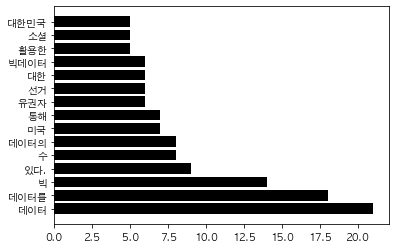

In [71]:
k=list()
v=list()
for i in wc3:
    v.append(i[0])
    k.append(i[1])
    
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.barh(range(len(v)), v, color = 'black')
plt.yticks(range(len(v)), k)
plt.show()

# combine by key

In [72]:
marks = spark.sparkContext.parallelize([('kim',86),('lim',87),('kim',75),
                                      ('kim',91),('lim',78),('lim',92),
                                      ('lim',79),('lee',99)])

marksByKey = marks.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))

marksByKey.collect()

[('kim', (252, 3)), ('lim', (336, 4)), ('lee', (99, 1))]

In [73]:
heights = spark.sparkContext.parallelize([
        ('M',182.),('F',164.),('M',180.),('M',185.),('M',171.),('F',162.)
    ])

heightsByKey = heights.combineByKey(lambda value: (value,1),
                             lambda x,value: (x[0]+value, x[1]+1),
                             lambda x,y: (x[0]+y[0], x[1]+y[1]))


avgByKey = heightsByKey.map(lambda x: (x[0],x[1][0]/x[1][1]))

print (avgByKey.collectAsMap())

{'M': 179.5, 'F': 163.0}


# reduce by key 단어 카운트

In [76]:
#from operator import add
wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

wcReduceByKey = wc.reduceByKey(lambda x,y:x+y)
wcReduceByKey.sortByKey().take(10)

[('amplab', 1),
 ('an', 2),
 ('and', 1),
 ('apache', 6),
 ('at', 1),
 ("berkeley's", 1),
 ('california', 1),
 ('cluster', 1),
 ('clusters', 1),
 ('codebase', 1)]

# json to DataFrame

In [13]:
import requests

r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

In [82]:
from pyspark.sql import Row

wcDf = spark.createDataFrame(Row(**x) for x in wc)
wcDf.printSchema()

root
 |-- Competition: string (nullable = true)
 |-- Year: long (nullable = true)
 |-- Team: string (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)



In [83]:
cols = wcDf.columns
cols.remove('IsCaptain')

# RDD to DataFrame

In [80]:
wcRdd=spark.sparkContext.parallelize(wc)
wcDfFromRdd = spark.createDataFrame(wcRdd)
wcDfFromRdd.printSchema()

root
 |-- Club: string (nullable = true)
 |-- ClubCountry: string (nullable = true)
 |-- Competition: string (nullable = true)
 |-- DateOfBirth: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- IsCaptain: boolean (nullable = true)
 |-- Number: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Team: string (nullable = true)
 |-- Year: long (nullable = true)



# 형변환

In [87]:
from pyspark.sql.functions import udf
from pyspark.sql.functions import to_date

_wcDfCasted=wcDf.withColumn('date2', to_date(wcDf['DateOfBirth'], 'yyyy-MM-dd'))

In [88]:
from pyspark.sql.types import DateType

wcDfCasted = _wcDfCasted.withColumn('date3', _wcDfCasted['DateOfBirth'].cast(DateType()))
wcDfCasted = wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))

# DataFrame cast

In [89]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

In [90]:
tDf = tDf.withColumn("id", tDf._c0.cast("integer"))
tDf = tDf.withColumn("height", tDf['_c1'].cast("double"))
tDf = tDf.withColumn("weight", tDf['_c2'].cast("double"))

In [91]:
tDf = tDf.drop('_c0').drop('_c1').drop('_c2')

# udf

In [96]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

In [98]:
def uppercase(s):
    return s.upper()

In [99]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

upperUdf = udf(uppercase, StringType())

In [100]:
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))

In [101]:
myDf.show()

+---+----+-------+------+---------+
|_c0|year|   name|height|nameUpper|
+---+----+-------+------+---------+
|  0|   1|kim, js|   170|  KIM, JS|
|  1|   1|lee, sm|   175|  LEE, SM|
|  2|   2|lim, yg|   180|  LIM, YG|
|  3|   2|    lee|   170|      LEE|
+---+----+-------+------+---------+



In [106]:
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x), DoubleType())
myDf = myDf.withColumn("heightD", toDoublefunc(myDf.height))

In [102]:
from pyspark.sql.types import IntegerType

toint=udf(lambda x:int(x), IntegerType())
myDf=myDf.withColumn("yearI", toint(myDf['year']))

myDf.show()

+---+----+-------+------+---------+-----+
|_c0|year|   name|height|nameUpper|yearI|
+---+----+-------+------+---------+-----+
|  0|   1|kim, js|   170|  KIM, JS|    1|
|  1|   1|lee, sm|   175|  LEE, SM|    1|
|  2|   2|lim, yg|   180|  LIM, YG|    2|
|  3|   2|    lee|   170|      LEE|    2|
+---+----+-------+------+---------+-----+



In [109]:
from pyspark.sql.types import StringType

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))

heightDf.show()

+---+----+-------+------+---------+-----+-------+----------+
|_c0|year|   name|height|nameUpper|yearI|heightD|height>175|
+---+----+-------+------+---------+-----+-------+----------+
|  0|   1|kim, js|   170|  KIM, JS|    1|  170.0|   shorter|
|  1|   1|lee, sm|   175|  LEE, SM|    1|  175.0|    taller|
|  2|   2|lim, yg|   180|  LIM, YG|    2|  180.0|    taller|
|  3|   2|    lee|   170|      LEE|    2|  170.0|   shorter|
+---+----+-------+------+---------+-----+-------+----------+



# spark 그래프 

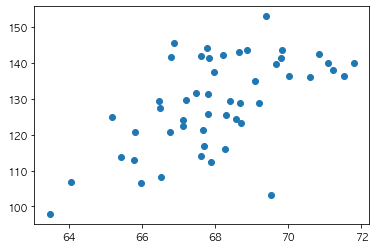

In [111]:
tDf=tDf.withColumnRenamed('id','ID')

_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'o')
plt.show()

# F함수, agg

In [112]:
from pyspark.sql import functions as F
tDf.agg(F.min("height")).show()

+-----------+
|min(height)|
+-----------+
|      63.48|
+-----------+



# alias

In [114]:
myDf1 = myDf.alias("myDf1")
myDf1.select(myDf1.name.substr(1,3).alias("short name")).show(3)

+----------+
|short name|
+----------+
|       kim|
|       lee|
|       lim|
+----------+
only showing top 3 rows



# zscore

In [11]:
marks=[
    "김하나, English, 100",
    "김하나, Math, 80",
    "임하나, English, 70",
    "임하나, Math, 100",
    "김갑돌, English, 82.3",
    "김갑돌, Math, 98.5"
]

In [2]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [14]:
temp = spark.sparkContext.parallelize(marks).map(lambda x : x.split(',')).map(lambda x : (x[0],x[1],float(x[2]))).collect()

In [23]:
score_df = spark.createDataFrame(temp,['name','subject','score'])

In [20]:
# 스키마 오류시
from pyspark.sql.types import *

schema = StructType([
    StructField("name", StringType(), True),
    StructField("subject", StringType(), True),
    StructField("score", FloatType(), True)
])
spark.createDataFrame(temp,schema=schema).show()

+------+--------+-----+
|  name| subject|score|
+------+--------+-----+
|김하나| English|100.0|
|김하나|    Math| 80.0|
|임하나| English| 70.0|
|임하나|    Math|100.0|
|김갑돌| English| 82.3|
|김갑돌|    Math| 98.5|
+------+--------+-----+



In [25]:
from pyspark.sql import functions as F

score_df.select(
    F.mean('score').alias('mean'),
    F.stddev('score').alias('std')
).collect()

[Row(mean=88.46666666666665, std=12.786190467323202)]

In [34]:
temp_val = score_df.select(F.mean('score'),F.stddev('score')).collect()

mean_data = temp_val[0][0]
std_data = temp_val[0][1]

In [38]:
get_zscore = F.udf(lambda x : (x-mean_data)/std_data,FloatType())
zscore_udf = score_df.withColumn('zscore', get_zscore('score'))

In [42]:
from scipy.stats import norm

get_cdf = F.udf(lambda x : float(norm.cdf(x)),FloatType())
mydf = zscore_udf.withColumn('cdf',get_cdf(zscore_udf['zscore']))
mydf.show()

+------+--------+-----+-----------+-----------+
|  name| subject|score|     zscore|        cdf|
+------+--------+-----+-----------+-----------+
|김하나| English|100.0| 0.90201485|  0.8164755|
|김하나|    Math| 80.0|-0.66217273| 0.25393027|
|임하나| English| 70.0| -1.4442666|0.074332014|
|임하나|    Math|100.0| 0.90201485|  0.8164755|
|김갑돌| English| 82.3|-0.48229116| 0.31479958|
|김갑돌|    Math| 98.5| 0.78470075|  0.7836855|
+------+--------+-----+-----------+-----------+



# 사망자

In [ ]:
import os
import src.mylib

keyPath=os.path.join(os.getcwd(), 'src', 'key.properties')
key=src.mylib.getKey(keyPath)
KEY = str(key['dataseoul'])

#api
TYPE='json'
SERVICE = 'SearchSTNBySubwayLineInfo'
START_INDEX=str(1)
END_INDEX=str(10)
LINE_NUM=str(2)

params='/'.join([KEY,TYPE,SERVICE,START_INDEX,END_INDEX,'','',LINE_NUM])

_url = 'http://openAPI.seoul.go.kr:8088'
url='/'.join([_url,params])

In [68]:
# !nbmerge "필요한거 모음", "어택, 단어, zscore" > merged.ipynb

Traceback (most recent call last):
  File "/opt/anaconda3/bin/nbmerge", line 8, in <module>
    sys.exit(main())
  File "/opt/anaconda3/lib/python3.8/site-packages/nbmerge/__init__.py", line 189, in main
    plan = parse_plan(args)
  File "/opt/anaconda3/lib/python3.8/site-packages/nbmerge/__init__.py", line 173, in parse_plan
    raise IOError("Notebook `{}` does not exist".format(file_path))
OSError: Notebook `필요한거 모음,` does not exist


# 요약2 부분

In [4]:
import os

kddcup = os.path.join(os.getcwd(),'kddcup.data_10_percent.gz')

In [5]:
import pyspark 

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder.master("local").appName("myApp").config(conf=myConf).getOrCreate()

In [6]:
rdd_data = spark.sparkContext.textFile(kddcup)

In [9]:
rdd_data.take(1)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

In [11]:
rdd_data.take(1)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.']

In [35]:
from pyspark.sql import Row

temp_data = rdd_data.map(lambda x : x.split(','))
temp_data = temp_data.map(lambda p: Row(
                        duration=int(p[0]), 
                        protocol=p[1],
                        service=p[2],
                        flag=p[3],
                        src_bytes=int(p[4]),
                        dst_bytes=int(p[5]),
                        attack=p[41]
                    )
                )

In [36]:
df_data = spark.createDataFrame(temp_data)
df_data.show()

+--------+--------+-------+----+---------+---------+-------+
|duration|protocol|service|flag|src_bytes|dst_bytes| attack|
+--------+--------+-------+----+---------+---------+-------+
|       0|     tcp|   http|  SF|      181|     5450|normal.|
|       0|     tcp|   http|  SF|      239|      486|normal.|
|       0|     tcp|   http|  SF|      235|     1337|normal.|
|       0|     tcp|   http|  SF|      219|     1337|normal.|
|       0|     tcp|   http|  SF|      217|     2032|normal.|
|       0|     tcp|   http|  SF|      217|     2032|normal.|
|       0|     tcp|   http|  SF|      212|     1940|normal.|
|       0|     tcp|   http|  SF|      159|     4087|normal.|
|       0|     tcp|   http|  SF|      210|      151|normal.|
|       0|     tcp|   http|  SF|      212|      786|normal.|
|       0|     tcp|   http|  SF|      210|      624|normal.|
|       0|     tcp|   http|  SF|      177|     1985|normal.|
|       0|     tcp|   http|  SF|      222|      773|normal.|
|       0|     tcp|   ht

In [37]:
df_data.groupBy('attack').count().show()

+----------------+------+
|          attack| count|
+----------------+------+
|    warezmaster.|    20|
|          smurf.|280790|
|            pod.|   264|
|           imap.|    12|
|           nmap.|   231|
|   guess_passwd.|    53|
|        ipsweep.|  1247|
|      portsweep.|  1040|
|          satan.|  1589|
|           land.|    21|
|     loadmodule.|     9|
|      ftp_write.|     8|
|buffer_overflow.|    30|
|        rootkit.|    10|
|    warezclient.|  1020|
|       teardrop.|   979|
|           perl.|     3|
|            phf.|     4|
|       multihop.|     7|
|        neptune.|107201|
+----------------+------+
only showing top 20 rows



In [40]:
df_data.groupBy('attack').mean('duration').show()

+----------------+--------------------+
|          attack|       avg(duration)|
+----------------+--------------------+
|    warezmaster.|               15.05|
|          smurf.|                 0.0|
|            pod.|                 0.0|
|           imap.|                 6.0|
|           nmap.|                 0.0|
|   guess_passwd.|  2.7169811320754715|
|        ipsweep.|0.034482758620689655|
|      portsweep.|  1915.2990384615384|
|          satan.|0.040276903713027064|
|           land.|                 0.0|
|     loadmodule.|   36.22222222222222|
|      ftp_write.|              32.375|
|buffer_overflow.|                91.7|
|        rootkit.|               100.8|
|    warezclient.|   615.2578431372549|
|       teardrop.|                 0.0|
|           perl.|  41.333333333333336|
|            phf.|                 4.5|
|       multihop.|               184.0|
|        neptune.|                 0.0|
+----------------+--------------------+
only showing top 20 rows



In [47]:
from pyspark.sql import functions as F

df_data.groupBy('attack').pivot('protocol').agg(F.mean('src_bytes')).show()

+----------------+------------------+------------------+------------------+
|          attack|              icmp|               tcp|               udp|
+----------------+------------------+------------------+------------------+
|    warezmaster.|              null|              49.3|              null|
|          smurf.| 935.7722995833185|              null|              null|
|            pod.|1462.6515151515152|              null|              null|
|           nmap.|               8.0|               0.0|            189.88|
|           imap.|              null| 347.5833333333333|              null|
|   guess_passwd.|              null|125.33962264150944|              null|
|        ipsweep.|10.905464006938422|               0.0|              null|
|      portsweep.|               8.0| 667349.1106833494|              null|
|          satan.|25.666666666666668| 1.323446327683616|1.0235294117647058|
|           land.|              null|               0.0|              null|
|     loadmo

In [48]:
df_data.groupBy('attack').pivot('protocol').mean('src_bytes').show()

+----------------+------------------+------------------+------------------+
|          attack|              icmp|               tcp|               udp|
+----------------+------------------+------------------+------------------+
|    warezmaster.|              null|              49.3|              null|
|          smurf.| 935.7722995833185|              null|              null|
|            pod.|1462.6515151515152|              null|              null|
|           nmap.|               8.0|               0.0|            189.88|
|           imap.|              null| 347.5833333333333|              null|
|   guess_passwd.|              null|125.33962264150944|              null|
|        ipsweep.|10.905464006938422|               0.0|              null|
|      portsweep.|               8.0| 667349.1106833494|              null|
|          satan.|25.666666666666668| 1.323446327683616|1.0235294117647058|
|           land.|              null|               0.0|              null|
|     loadmo

In [53]:
wiki_data

data/ds_bigdata_wiki.txt MapPartitionsRDD[134] at textFile at NativeMethodAccessorImpl.java:0

In [52]:
wiki_data = spark.sparkContext.textFile(os.path.join('data','ds_bigdata_wiki.txt'))

In [63]:
wiki_data.flatMap(lambda x : x.split()).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).map(lambda x : (x[1],x[0])).sortByKey(False).take(15)

[(21, '데이터'),
 (18, '데이터를'),
 (15, '및'),
 (14, '빅'),
 (12, '등'),
 (9, '있다.'),
 (8, '수'),
 (8, '데이터의'),
 (7, '미국'),
 (7, '통해'),
 (6, '유권자'),
 (6, '선거'),
 (6, '대한'),
 (6, '빅데이터'),
 (5, '활용한')]

In [65]:
wiki_data.flatMap(lambda x : x.split()).map(lambda x: (x,1)).groupByKey().mapValues(sum).map(lambda x: (x[1],x[0])).sortByKey(False).take(15)

[(21, '데이터'),
 (18, '데이터를'),
 (15, '및'),
 (14, '빅'),
 (12, '등'),
 (9, '있다.'),
 (8, '수'),
 (8, '데이터의'),
 (7, '미국'),
 (7, '통해'),
 (6, '유권자'),
 (6, '선거'),
 (6, '대한'),
 (6, '빅데이터'),
 (5, '활용한')]

In [66]:
_data = ["'김하나','English',100",
         "'김하나','Math',80",
         "'임하나','English',70",
         "'임하나','Math',100",
        "'김갑돌','English',82.3",
         "'김갑돌','Math',98.5"]

In [74]:
rdd_data = spark.sparkContext.parallelize(_data)
rdd_data.map(lambda x: x.split(',')).map(lambda x : (x[0],float(x[2]))).reduceByKey(lambda x,y : x+y).collect()

[("'김하나'", 180.0), ("'임하나'", 170.0), ("'김갑돌'", 180.8)]

In [75]:
rdd_data.map(lambda x: x.split(',')).map(lambda x : (x[1],float(x[2]))).reduceByKey(lambda x,y : x+y).collect()

[("'English'", 252.3), ("'Math'", 278.5)]

In [84]:
rdd_data.map(lambda x: x.split(',')).map(lambda x: (x[0], float(x[2]))).combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1])).collect()

[("'김하나'", (180.0, 2)), ("'임하나'", (170.0, 2)), ("'김갑돌'", (180.8, 2))]

In [87]:
avg = rdd_data.map(lambda x: x.split(',')).map(lambda x: (x[0], float(x[2]))).combineByKey(lambda value: (value,1),
                     lambda x,value: (x[0]+value, x[1]+1),                      
                     lambda x,y: (x[0]+y[0], x[1]+y[1]))

avg2 = avg.map(lambda x: (x[0],x[1][0]/x[1][1]))

for i, j in sorted(avg2.collect(),reverse=True):
    print(i,j)

'임하나' 85.0
'김하나' 90.0
'김갑돌' 90.4


In [89]:
r = requests.get('https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD')

wc = r.json()

In [110]:
wc['meta']['view']['columns'][1]

{'id': -1,
 'name': 'id',
 'dataTypeName': 'meta_data',
 'fieldName': ':id',
 'position': 0,
 'renderTypeName': 'meta_data',
 'format': {},
 'flags': ['hidden']}

# RDD 읽는 방법

In [ ]:
spark.sparkContext.parallelize(myList)
spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))


# DF 읽는 방법 

In [ ]:
spark.read.text(os.path.join("data", "ds_spark_wiki.txt"))

popDf = spark\
            .read.option("charset", "euc-kr")\
            .option("header", "true")\
            .csv(os.path.join("data","경기도 의정부시_인구현황_20200904.csv"))

df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true', delimiter=',')\
        .load(os.path.join('data','ds_spark.csv'))

df = spark\
        .read.options(header='true', inferschema='true', delimiter=',')\
        .csv(os.path.join('data', 'ds_spark.csv'))

# RDD to DF

In [112]:
rddDf=spark.createDataFrame(myRdd)

# row to df
from pyspark.sql import Row
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]), name=x[1], height=int(x[2])))
_myDf=spark.createDataFrame(_myRdd)



#structType
from pyspark.sql.types import *
myRdd=spark.sparkContext.parallelize([(1, 'kim', 50.0), (2, 'lee', 60.0), (3, 'park', 70.0)])
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("height", DoubleType(), True)
])
_myDf = spark.createDataFrame(myRdd, schema)

NameError: name 'myRdd' is not defined

# json to spark_df

In [ ]:
jfile= os.path.join('src','ds_twitter_seoul_3.json')
tweetDf= spark.read.json(jfile)

In [ ]:
# url json spark_df

r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()
_wcDf=spark.createDataFrame(wc)

# csv 읽는 방법 

In [ ]:
# 한글깨짐
spark.sparkContext.textFile(os.path.join("data","ds_spark_2cols.csv"))

# 한글안깨짐
popRddBin = spark.sparkContext.binaryFiles(os.path.join("../data","경기도 의정부시_인구현황_20210910.csv"))
_my = popRddBin.map(lambda x :x[1].decode('euc-kr'))



# filter


In [ ]:
stopwords = ['is','am','are','the','for','a', 'an', 'at']
myRdd_stop = myRdd2.flatMap(lambda x:x.split())\
                    .filter(lambda x: x not in stopwords)

for words in myRdd_stop.collect():
    print (words, end=' ')

# 불용어

In [ ]:
# txt 읽어서 불용어 및 단어빈도
import os

f=open(os.path.join("data", "ds_bigdata_wiki.txt"))

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])
d = dict()
for sent in f.readlines():
    _words = sent.split()  # split into words
    for word in _words:
        if word not in stopwords: # remove stopwords
            if word not in d:
                d[word]=1
            else:
                d[word]=d[word]+1
# sorting
dSorted = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}

#빈도 5 이상
d1 = dict()
for key, value in dSorted.items():
    if value>5:
        d1[key]=value
        print (f"{key}\t{value}")

In [111]:
# rdd 불용어 + sorting

stopwords = set(['및','이를','등','이','이런','그와','또는','두', '이와', '전', '간'])

wc3=myRdd3\
    .flatMap(lambda x:x.split())\
    .filter(lambda x: x.lower() not in stopwords)\
    .map(lambda x:(x,1))\
    .reduceByKey(lambda x,y:x+y)\
    .map(lambda x:(x[1],x[0]))\
    .sortByKey(False)\
    .take(15)

print (type(wc3))
for i in wc3:
    print (i[0],i[1])

In [ ]:
# 공백 + , + .제거

wc = spark.sparkContext.textFile(os.path.join("data","ds_spark_wiki.txt"))\
    .flatMap(lambda x: x.split())\
    .map(lambda x: (x.lower().rstrip().lstrip().rstrip(',').rstrip('.'), 1))

wcReduceByKey = wc.reduceByKey(lambda x,y:x+y)
wcReduceByKey.sortByKey().take(10)

# datetime

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType
toDate = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

_wcDfCasted=wcDf.withColumn('date2', to_date(wcDf['DateOfBirth'], 'yyyy-MM-dd'))

# udf 조건

In [ ]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))

# columnRenamed

In [ ]:
tDf=tDf.withColumnRenamed('id','ID')

# F함수

In [ ]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()
tDf.agg(F.min("height")).show()